<a href="https://colab.research.google.com/github/degru82/datasci_2020/blob/master/subway_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np



# 승하차 데이터

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/15QVZaX8wGTVFvk19875HS5rHDcR-IcVL/view?usp=sharing'

In [ ]:
id = link.split('/')[5]
print(id)

15QVZaX8wGTVFvk19875HS5rHDcR-IcVL


In [ ]:
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('서울교통공사 2019년 일별 역별 시간대별 승하차인원(1_8호선).xlsx')
df = pd.read_excel('서울교통공사 2019년 일별 역별 시간대별 승하차인원(1_8호선).xlsx', skiprows=1)

In [ ]:
df.head()

,날짜,호선,역번호,역명,구분,06시 이전,06 ~ 07,07 ~ 08,08 ~ 09,09 ~ 10,10 ~ 11,11 ~ 12,12 ~ 13,13 ~ 14,14 ~ 15,15 ~ 16,16 ~ 17,17 ~ 18,18 ~ 19,19 ~ 20,20 ~ 21,21 ~ 22,22 ~ 23,23 ~ 24,24시 이후,합 계
0,2019-01-01,1호선,150,서울역,승차,348,321,348,741,940,1401,2166,2844,3055,2341,3370,3226,3447,3277,2898,2590,3004,2234,970,38,39559
1,2019-01-01,1호선,150,서울역,하차,222,821,808,961,1472,1737,1917,2316,2539,2360,2743,2491,2572,2060,1991,1683,1217,764,456,149,31279
2,2019-01-01,1호선,151,시청,승차,87,98,143,206,280,395,500,672,673,868,946,958,1062,1146,1119,992,904,570,211,6,11836
3,2019-01-01,1호선,151,시청,하차,48,237,323,571,577,648,744,960,996,875,964,733,746,606,374,311,268,177,144,57,10359
4,2019-01-01,1호선,152,종각,승차,669,318,217,203,333,365,666,802,1103,1294,1843,1870,2129,2024,1806,1796,1780,1296,497,31,21042


In [ ]:
df_psngr = df.copy(deep=True)
df_psngr.head()

,날짜,호선,역번호,역명,구분,06시 이전,06 ~ 07,07 ~ 08,08 ~ 09,09 ~ 10,10 ~ 11,11 ~ 12,12 ~ 13,13 ~ 14,14 ~ 15,15 ~ 16,16 ~ 17,17 ~ 18,18 ~ 19,19 ~ 20,20 ~ 21,21 ~ 22,22 ~ 23,23 ~ 24,24시 이후,합 계
0,2019-01-01,1호선,150,서울역,승차,348,321,348,741,940,1401,2166,2844,3055,2341,3370,3226,3447,3277,2898,2590,3004,2234,970,38,39559
1,2019-01-01,1호선,150,서울역,하차,222,821,808,961,1472,1737,1917,2316,2539,2360,2743,2491,2572,2060,1991,1683,1217,764,456,149,31279
2,2019-01-01,1호선,151,시청,승차,87,98,143,206,280,395,500,672,673,868,946,958,1062,1146,1119,992,904,570,211,6,11836
3,2019-01-01,1호선,151,시청,하차,48,237,323,571,577,648,744,960,996,875,964,733,746,606,374,311,268,177,144,57,10359
4,2019-01-01,1호선,152,종각,승차,669,318,217,203,333,365,666,802,1103,1294,1843,1870,2129,2024,1806,1796,1780,1296,497,31,21042


# 날씨 데이터

In [ ]:
import requests
from bs4 import BeautifulSoup


def convert_weatherlog_to_bsoup(year: int, month: int) -> BeautifulSoup:

    base_url = 'http://www.weather.go.kr/weather/climate/past_cal.jsp?'
    fields = {
        'stn': 108,
        'yy': year,
        'mm': month,
        'obs': 1,
        'x': 20,
        'y': 10
    }

    query_arr = []
    for k, v in fields.items():
        query_arr.append(str(k) + '=' + str(v))

    query_str = '&'.join(query_arr)
    response = requests.get(base_url + query_str)

    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [ ]:
import re


def dictionarize_weather(weatherdata: list) -> dict:

    w_dict = {}
    
    for wd in weatherdata:

        if wd == '':
            continue

        k, v = wd.split(':')

        v = re.sub('[℃m]', '', v)
        if v == ' - ':
            v = None


        w_dict[k] = v

    return w_dict

In [ ]:
def convert_bsoup_to_dict(bsoup: BeautifulSoup, year: int, month: int) -> dict:

    weatherlogs = {}

    tables = bsoup.find_all('table', class_='table_develop')
    table_tag = tables[0]
    tbody_tag = table_tag.tbody
    tablerows = tbody_tag.find_all('tr')

    trows_date = tablerows[::2]
    trows_weather = tablerows[1::2]

    for tr_date, tr_wthr in zip(trows_date, trows_weather):
        for td_date, td_wthr in zip(tr_date, tr_wthr):

            if '일' not in td_date.string:
                continue

            dateday = str(year) + '-' + str(month) + '-' + td_date.string[:-1]
            weatherdata = str(td_wthr)[23:-5].split('<br/>')

            weatherlogs[dateday] = dictionarize_weather(weatherdata)

    return weatherlogs


In [ ]:
import pandas as pd



year = 2019
months = range(1, 13)

dataframes_12mon = []

for m in months:
    soup = convert_weatherlog_to_bsoup(year, m)
    w_dict = convert_bsoup_to_dict(soup, year, m)

    df = pd.DataFrame(w_dict).T
    dataframes_12mon.append(df)

df_concat = pd.concat(dataframes_12mon)
df_concat = df_concat.reset_index()



In [ ]:
df_concat['날짜'] = pd.to_datetime(df_concat['index'], format='%Y-%m-%d')
df_concat['평균기온'] = pd.to_numeric(df_concat['평균기온'])
df_concat['최고기온'] = pd.to_numeric(df_concat['최고기온'])
df_concat['최저기온'] = pd.to_numeric(df_concat['평균운량'])
df_concat['평균운량'] = pd.to_numeric(df_concat['평균운량'])
df_concat['일강수량'] = pd.to_numeric(df_concat['일강수량'])
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   365 non-null    object        
 1   평균기온    365 non-null    float64       
 2   최고기온    365 non-null    float64       
 3   최저기온    365 non-null    float64       
 4   평균운량    365 non-null    float64       
 5   일강수량    139 non-null    float64       
 6   날짜      365 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 20.1+ KB


# 대기오염 데이터

In [ ]:
from io import StringIO

import requests
import pandas as pd


In [ ]:
url = 'http://odc.data.seoul.go.kr/bigfile/iot/inf/nio_download.do?&useCache=false'
data = {
    'infId': 'OA-2220',
    'seqNo': None,
    'seq': '17',
    'infSeq': '3'
}

airpollut_csv = requests.post(url, data).text
csv_data = StringIO(airpollut_csv)

airpollution = pd.read_csv(csv_data)
airpollution

,측정일자,권역코드,권역명,측정소코드,측정소명,미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),초미세먼지(㎍/㎥)
0,20191231,100,도심권,111121,중구,26,18,0.023,0.012,0.4,0.002
1,20191231,100,도심권,111123,종로구,27,19,0.021,0.015,0.4,0.003
2,20191231,100,도심권,111131,용산구,14,15,0.020,0.015,0.4,0.003
3,20191231,101,서북권,111181,은평구,24,13,0.024,0.010,0.4,0.003
4,20191231,101,서북권,111191,서대문구,23,9,0.023,0.013,0.5,0.002
...,...,...,...,...,...,...,...,...,...,...,...
8891,20190101,103,서남권,111301,양천구,46,29,0.014,0.033,0.6,0.002
8892,20190101,104,동남권,111261,강남구,37,31,0.012,0.028,0.6,0.005
8893,20190101,104,동남권,111262,서초구,37,20,0.015,0.032,0.4,0.004
8894,20190101,104,동남권,111273,송파구,44,28,0.011,0.042,0.8,0.004


In [ ]:
fields_pollution = [
    '미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소농도(ppm)', '일산화탄소농도(ppm)',
    '아황산가스농도(ppm)', '초미세먼지(㎍/㎥)'
]

df_airpol = \
    airpollution.groupby('측정일자')[fields_pollution].mean().reset_index()
    
df_airpol

,측정일자,미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),초미세먼지(㎍/㎥)
0,20190101,39.36,26.12,0.01472,0.03156,0.692,0.00428
1,20190102,33.08,21.36,0.01256,0.03524,0.676,0.00464
2,20190103,38.80,23.36,0.00716,0.04344,0.736,0.00504
3,20190104,59.44,40.36,0.00368,0.05896,1.060,0.00600
4,20190105,65.72,42.52,0.01788,0.02812,0.644,0.00512
...,...,...,...,...,...,...,...
351,20191227,34.16,23.36,0.01956,0.02608,0.532,0.00328
352,20191228,42.04,24.72,0.00620,0.04324,0.676,0.00372
353,20191229,45.36,27.48,0.00892,0.03732,0.660,0.00348
354,20191230,36.76,25.68,0.01132,0.03304,0.628,0.00308


In [ ]:
df_airpol['날짜'] = pd.to_datetime(df_airpol['측정일자'], format='%Y%m%d')
df_airpol

,측정일자,미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),초미세먼지(㎍/㎥),날짜
0,20190101,39.36,26.12,0.01472,0.03156,0.692,0.00428,2019-01-01
1,20190102,33.08,21.36,0.01256,0.03524,0.676,0.00464,2019-01-02
2,20190103,38.80,23.36,0.00716,0.04344,0.736,0.00504,2019-01-03
3,20190104,59.44,40.36,0.00368,0.05896,1.060,0.00600,2019-01-04
4,20190105,65.72,42.52,0.01788,0.02812,0.644,0.00512,2019-01-05
...,...,...,...,...,...,...,...,...
351,20191227,34.16,23.36,0.01956,0.02608,0.532,0.00328,2019-12-27
352,20191228,42.04,24.72,0.00620,0.04324,0.676,0.00372,2019-12-28
353,20191229,45.36,27.48,0.00892,0.03732,0.660,0.00348,2019-12-29
354,20191230,36.76,25.68,0.01132,0.03304,0.628,0.00308,2019-12-30


In [ ]:
df_airpol.columns

Index(['측정일자', '미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소농도(ppm)', '일산화탄소농도(ppm)',
       '아황산가스농도(ppm)', '초미세먼지(㎍/㎥)', '날짜'],
      dtype='object')

In [ ]:
df_airpol.columns=[
    '측정일자', '미세먼지', '오존', '이산화질소농도', '일산화탄소농도', '아황산가스농도', '초미세먼지', '날짜'
]


In [ ]:
df_airpol = df_airpol.drop('측정일자', axis=1)
df_airpol

,미세먼지,오존,이산화질소농도,일산화탄소농도,아황산가스농도,초미세먼지,날짜
0,39.36,26.12,0.01472,0.03156,0.692,0.00428,2019-01-01
1,33.08,21.36,0.01256,0.03524,0.676,0.00464,2019-01-02
2,38.80,23.36,0.00716,0.04344,0.736,0.00504,2019-01-03
3,59.44,40.36,0.00368,0.05896,1.060,0.00600,2019-01-04
4,65.72,42.52,0.01788,0.02812,0.644,0.00512,2019-01-05
...,...,...,...,...,...,...,...
351,34.16,23.36,0.01956,0.02608,0.532,0.00328,2019-12-27
352,42.04,24.72,0.00620,0.04324,0.676,0.00372,2019-12-28
353,45.36,27.48,0.00892,0.03732,0.660,0.00348,2019-12-29
354,36.76,25.68,0.01132,0.03304,0.628,0.00308,2019-12-30


# 데이터셋 통합

In [ ]:
df_concat

,index,평균기온,최고기온,최저기온,평균운량,일강수량,날짜
0,2019-1-1,-5.0,-0.6,3.4,3.4,NaN,2019-01-01
1,2019-1-2,-4.9,0.2,0.0,0.0,NaN,2019-01-02
2,2019-1-3,-3.5,3.2,0.1,0.1,NaN,2019-01-03
3,2019-1-4,-1.1,4.1,5.5,5.5,NaN,2019-01-04
4,2019-1-5,-2.8,1.1,0.5,0.5,NaN,2019-01-05
...,...,...,...,...,...,...,...
360,2019-12-27,-1.7,2.6,0.0,0.0,NaN,2019-12-27
361,2019-12-28,1.1,6.1,3.5,3.5,NaN,2019-12-28
362,2019-12-29,3.8,6.2,9.0,9.0,1.4,2019-12-29
363,2019-12-30,2.7,6.8,7.5,7.5,0.4,2019-12-30


In [ ]:
df_merged = pd.merge(
    df_psngr,
    df_concat[['날짜',  '평균기온',  '최고기온',  '평균운량',  '일강수량']], 
    on='날짜',
    how='left'
)

df_merged

,날짜,호선,역번호,역명,구분,06시 이전,06 ~ 07,07 ~ 08,08 ~ 09,09 ~ 10,10 ~ 11,11 ~ 12,12 ~ 13,13 ~ 14,14 ~ 15,15 ~ 16,16 ~ 17,17 ~ 18,18 ~ 19,19 ~ 20,20 ~ 21,21 ~ 22,22 ~ 23,23 ~ 24,24시 이후,합 계,평균기온,최고기온,평균운량,일강수량
0,2019-01-01,1호선,150,서울역,승차,348,321,348,741,940,1401,2166,2844,3055,2341,3370,3226,3447,3277,2898,2590,3004,2234,970,38,39559,-5.0,-0.6,3.4,NaN
1,2019-01-01,1호선,150,서울역,하차,222,821,808,961,1472,1737,1917,2316,2539,2360,2743,2491,2572,2060,1991,1683,1217,764,456,149,31279,-5.0,-0.6,3.4,NaN
2,2019-01-01,1호선,151,시청,승차,87,98,143,206,280,395,500,672,673,868,946,958,1062,1146,1119,992,904,570,211,6,11836,-5.0,-0.6,3.4,NaN
3,2019-01-01,1호선,151,시청,하차,48,237,323,571,577,648,744,960,996,875,964,733,746,606,374,311,268,177,144,57,10359,-5.0,-0.6,3.4,NaN
4,2019-01-01,1호선,152,종각,승차,669,318,217,203,333,365,666,802,1103,1294,1843,1870,2129,2024,1806,1796,1780,1296,497,31,21042,-5.0,-0.6,3.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200799,2019-12-31,8호선,2825,신흥,하차,20,87,86,243,208,189,205,327,347,381,382,501,510,562,493,378,301,257,154,163,5794,-7.9,-4.5,1.3,0.0
200800,2019-12-31,8호선,2826,수진,승차,111,224,542,813,436,343,267,350,297,285,407,427,436,395,245,219,155,126,68,82,6228,-7.9,-4.5,1.3,0.0
200801,2019-12-31,8호선,2826,수진,하차,27,97,115,433,259,198,207,283,381,376,404,373,463,501,452,354,332,322,256,163,5996,-7.9,-4.5,1.3,0.0
200802,2019-12-31,8호선,2827,모란,승차,73,95,342,482,253,210,253,281,377,350,303,366,375,418,242,199,152,189,126,65,5151,-7.9,-4.5,1.3,0.0


In [ ]:
df_merged = pd.merge(
    df_merged,
    df_airpol,
    on='날짜',
    how='left'
)

df_merged

,날짜,호선,역번호,역명,구분,06시 이전,06 ~ 07,07 ~ 08,08 ~ 09,09 ~ 10,10 ~ 11,11 ~ 12,12 ~ 13,13 ~ 14,14 ~ 15,15 ~ 16,16 ~ 17,17 ~ 18,18 ~ 19,19 ~ 20,20 ~ 21,21 ~ 22,22 ~ 23,23 ~ 24,24시 이후,합 계,평균기온,최고기온,평균운량,일강수량,미세먼지,오존,이산화질소농도,일산화탄소농도,아황산가스농도,초미세먼지
0,2019-01-01,1호선,150,서울역,승차,348,321,348,741,940,1401,2166,2844,3055,2341,3370,3226,3447,3277,2898,2590,3004,2234,970,38,39559,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
1,2019-01-01,1호선,150,서울역,하차,222,821,808,961,1472,1737,1917,2316,2539,2360,2743,2491,2572,2060,1991,1683,1217,764,456,149,31279,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
2,2019-01-01,1호선,151,시청,승차,87,98,143,206,280,395,500,672,673,868,946,958,1062,1146,1119,992,904,570,211,6,11836,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
3,2019-01-01,1호선,151,시청,하차,48,237,323,571,577,648,744,960,996,875,964,733,746,606,374,311,268,177,144,57,10359,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
4,2019-01-01,1호선,152,종각,승차,669,318,217,203,333,365,666,802,1103,1294,1843,1870,2129,2024,1806,1796,1780,1296,497,31,21042,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200799,2019-12-31,8호선,2825,신흥,하차,20,87,86,243,208,189,205,327,347,381,382,501,510,562,493,378,301,257,154,163,5794,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284
200800,2019-12-31,8호선,2826,수진,승차,111,224,542,813,436,343,267,350,297,285,407,427,436,395,245,219,155,126,68,82,6228,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284
200801,2019-12-31,8호선,2826,수진,하차,27,97,115,433,259,198,207,283,381,376,404,373,463,501,452,354,332,322,256,163,5996,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284
200802,2019-12-31,8호선,2827,모란,승차,73,95,342,482,253,210,253,281,377,350,303,366,375,418,242,199,152,189,126,65,5151,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284


In [ ]:
df_merged.columns = [
    'date', 'line_num', 'station_num', 'station_name', 'board_alight',
    '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
    '18', '19', '20', '21', '22', '23', '24', 'day_total', 'temp_avg',
    'temp_highest', 'cloud_avg', 'rain_daytotal', 'fine_dust', 'ozone', 'NO2',
    'CO', 'SO2', 'ultrafine_dust'
]

In [ ]:
df_merged

,date,line_num,station_num,station_name,board_alight,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,day_total,temp_avg,temp_highest,cloud_avg,rain_daytotal,fine_dust,ozone,NO2,CO,SO2,ultrafine_dust
0,2019-01-01,1호선,150,서울역,승차,348,321,348,741,940,1401,2166,2844,3055,2341,3370,3226,3447,3277,2898,2590,3004,2234,970,38,39559,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
1,2019-01-01,1호선,150,서울역,하차,222,821,808,961,1472,1737,1917,2316,2539,2360,2743,2491,2572,2060,1991,1683,1217,764,456,149,31279,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
2,2019-01-01,1호선,151,시청,승차,87,98,143,206,280,395,500,672,673,868,946,958,1062,1146,1119,992,904,570,211,6,11836,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
3,2019-01-01,1호선,151,시청,하차,48,237,323,571,577,648,744,960,996,875,964,733,746,606,374,311,268,177,144,57,10359,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
4,2019-01-01,1호선,152,종각,승차,669,318,217,203,333,365,666,802,1103,1294,1843,1870,2129,2024,1806,1796,1780,1296,497,31,21042,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200799,2019-12-31,8호선,2825,신흥,하차,20,87,86,243,208,189,205,327,347,381,382,501,510,562,493,378,301,257,154,163,5794,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284
200800,2019-12-31,8호선,2826,수진,승차,111,224,542,813,436,343,267,350,297,285,407,427,436,395,245,219,155,126,68,82,6228,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284
200801,2019-12-31,8호선,2826,수진,하차,27,97,115,433,259,198,207,283,381,376,404,373,463,501,452,354,332,322,256,163,5996,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284
200802,2019-12-31,8호선,2827,모란,승차,73,95,342,482,253,210,253,281,377,350,303,366,375,418,242,199,152,189,126,65,5151,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284


In [ ]:
df_merged['month'] = df_merged['date'].dt.month
df_merged['dayofweek'] = df_merged['date'].dt.dayofweek
df_merged['season'] = df_merged['month'].map({
    3: 0,
    4: 0,
    5: 0,
    6: 1,
    7: 1,
    8: 1,
    9: 2,
    10: 2,
    11: 2,
    12: 3,
    1: 3,
    2: 3
})

In [ ]:
df_merged['line_num'] = df_merged['line_num'].map({
    '1호선': 1,
    '2호선': 2,
    '3호선': 3,
    '4호선': 4,
    '5호선': 5,
    '6호선': 6,
    '7호선': 7,
    '8호선': 8 
})

In [ ]:
df_merged['board_alight'] = df_merged['board_alight'].map({
    '승차': 1,
    '하차': 0
})

In [ ]:
df_merged['board_alight'] == 1

0          True
1         False
2          True
3         False
4          True
          ...  
200799    False
200800     True
200801    False
200802     True
200803    False
Name: board_alight, Length: 200804, dtype: bool

In [ ]:
categorical_columns = [
    'line_num', 'station_num', 'board_alight', 'month', 'dayofweek', 'season'
]


for catcol in categorical_columns:
    df_merged[catcol] = df_merged[catcol].astype('category')

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200804 entries, 0 to 200803
Data columns (total 39 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            200804 non-null  datetime64[ns]
 1   line_num        200804 non-null  category      
 2   station_num     200804 non-null  category      
 3   station_name    200804 non-null  object        
 4   board_alight    200804 non-null  category      
 5   5               200804 non-null  int64         
 6   6               200804 non-null  int64         
 7   7               200804 non-null  int64         
 8   8               200804 non-null  int64         
 9   9               200804 non-null  int64         
 10  10              200804 non-null  int64         
 11  11              200804 non-null  int64         
 12  12              200804 non-null  int64         
 13  13              200804 non-null  int64         
 14  14              200804 non-null  int

In [ ]:
df_merged

,date,line_num,station_num,station_name,board_alight,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,day_total,temp_avg,temp_highest,cloud_avg,rain_daytotal,fine_dust,ozone,NO2,CO,SO2,ultrafine_dust,month,dayofweek,season
0,2019-01-01,1,150,서울역,1,348,321,348,741,940,1401,2166,2844,3055,2341,3370,3226,3447,3277,2898,2590,3004,2234,970,38,39559,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
1,2019-01-01,1,150,서울역,0,222,821,808,961,1472,1737,1917,2316,2539,2360,2743,2491,2572,2060,1991,1683,1217,764,456,149,31279,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
2,2019-01-01,1,151,시청,1,87,98,143,206,280,395,500,672,673,868,946,958,1062,1146,1119,992,904,570,211,6,11836,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
3,2019-01-01,1,151,시청,0,48,237,323,571,577,648,744,960,996,875,964,733,746,606,374,311,268,177,144,57,10359,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
4,2019-01-01,1,152,종각,1,669,318,217,203,333,365,666,802,1103,1294,1843,1870,2129,2024,1806,1796,1780,1296,497,31,21042,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200799,2019-12-31,8,2825,신흥,0,20,87,86,243,208,189,205,327,347,381,382,501,510,562,493,378,301,257,154,163,5794,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200800,2019-12-31,8,2826,수진,1,111,224,542,813,436,343,267,350,297,285,407,427,436,395,245,219,155,126,68,82,6228,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200801,2019-12-31,8,2826,수진,0,27,97,115,433,259,198,207,283,381,376,404,373,463,501,452,354,332,322,256,163,5996,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200802,2019-12-31,8,2827,모란,1,73,95,342,482,253,210,253,281,377,350,303,366,375,418,242,199,152,189,126,65,5151,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3


In [ ]:
for col in df_merged.columns:

    na_count = df_merged[col].isnull().sum()
    print(col, na_count)



date 0
line_num 0
station_num 0
station_name 0
board_alight 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
day_total 0
temp_avg 0
temp_highest 0
cloud_avg 0
rain_daytotal 124318
fine_dust 4950
ozone 4950
NO2 4950
CO 4950
SO2 4950
ultrafine_dust 4950
month 0
dayofweek 0
season 0


In [ ]:
df_merged[df_merged['NO2'].isnull()]['date'].unique()

array(['2019-03-09T00:00:00.000000000', '2019-03-10T00:00:00.000000000',
       '2019-03-11T00:00:00.000000000', '2019-03-12T00:00:00.000000000',
       '2019-03-13T00:00:00.000000000', '2019-03-16T00:00:00.000000000',
       '2019-03-17T00:00:00.000000000', '2019-09-07T00:00:00.000000000',
       '2019-09-08T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
df_cleanset = pd.DataFrame.copy(df_merged, deep=True)

In [ ]:
df_cleanset.dropna(
    subset=['NO2'],
    inplace=True
)

In [ ]:
df_cleanset

,date,line_num,station_num,station_name,board_alight,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,day_total,temp_avg,temp_highest,cloud_avg,rain_daytotal,fine_dust,ozone,NO2,CO,SO2,ultrafine_dust,month,dayofweek,season
0,2019-01-01,1,150,서울역,1,348,321,348,741,940,1401,2166,2844,3055,2341,3370,3226,3447,3277,2898,2590,3004,2234,970,38,39559,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
1,2019-01-01,1,150,서울역,0,222,821,808,961,1472,1737,1917,2316,2539,2360,2743,2491,2572,2060,1991,1683,1217,764,456,149,31279,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
2,2019-01-01,1,151,시청,1,87,98,143,206,280,395,500,672,673,868,946,958,1062,1146,1119,992,904,570,211,6,11836,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
3,2019-01-01,1,151,시청,0,48,237,323,571,577,648,744,960,996,875,964,733,746,606,374,311,268,177,144,57,10359,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
4,2019-01-01,1,152,종각,1,669,318,217,203,333,365,666,802,1103,1294,1843,1870,2129,2024,1806,1796,1780,1296,497,31,21042,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200799,2019-12-31,8,2825,신흥,0,20,87,86,243,208,189,205,327,347,381,382,501,510,562,493,378,301,257,154,163,5794,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200800,2019-12-31,8,2826,수진,1,111,224,542,813,436,343,267,350,297,285,407,427,436,395,245,219,155,126,68,82,6228,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200801,2019-12-31,8,2826,수진,0,27,97,115,433,259,198,207,283,381,376,404,373,463,501,452,354,332,322,256,163,5996,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200802,2019-12-31,8,2827,모란,1,73,95,342,482,253,210,253,281,377,350,303,366,375,418,242,199,152,189,126,65,5151,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3


In [ ]:
df_cleanset['rain_daytotal'] = df_cleanset['rain_daytotal'].fillna(0.0)

In [ ]:
for col in df_cleanset.columns:

    na_count = df_cleanset[col].isnull().sum()
    print(col, na_count)

date 0
line_num 0
station_num 0
station_name 0
board_alight 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
day_total 0
temp_avg 0
temp_highest 0
cloud_avg 0
rain_daytotal 0
fine_dust 0
ozone 0
NO2 0
CO 0
SO2 0
ultrafine_dust 0
month 0
dayofweek 0
season 0


In [ ]:
df_cleanset

,date,line_num,station_num,station_name,board_alight,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,day_total,temp_avg,temp_highest,cloud_avg,rain_daytotal,fine_dust,ozone,NO2,CO,SO2,ultrafine_dust,month,dayofweek,season
0,2019-01-01,1,150,서울역,1,348,321,348,741,940,1401,2166,2844,3055,2341,3370,3226,3447,3277,2898,2590,3004,2234,970,38,39559,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
1,2019-01-01,1,150,서울역,0,222,821,808,961,1472,1737,1917,2316,2539,2360,2743,2491,2572,2060,1991,1683,1217,764,456,149,31279,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
2,2019-01-01,1,151,시청,1,87,98,143,206,280,395,500,672,673,868,946,958,1062,1146,1119,992,904,570,211,6,11836,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
3,2019-01-01,1,151,시청,0,48,237,323,571,577,648,744,960,996,875,964,733,746,606,374,311,268,177,144,57,10359,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
4,2019-01-01,1,152,종각,1,669,318,217,203,333,365,666,802,1103,1294,1843,1870,2129,2024,1806,1796,1780,1296,497,31,21042,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200799,2019-12-31,8,2825,신흥,0,20,87,86,243,208,189,205,327,347,381,382,501,510,562,493,378,301,257,154,163,5794,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200800,2019-12-31,8,2826,수진,1,111,224,542,813,436,343,267,350,297,285,407,427,436,395,245,219,155,126,68,82,6228,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200801,2019-12-31,8,2826,수진,0,27,97,115,433,259,198,207,283,381,376,404,373,463,501,452,354,332,322,256,163,5996,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200802,2019-12-31,8,2827,모란,1,73,95,342,482,253,210,253,281,377,350,303,366,375,418,242,199,152,189,126,65,5151,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3


In [ ]:
df_cleanset.columns

Index(['date', 'line_num', 'station_num', 'station_name', 'board_alight', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', 'day_total', 'temp_avg',
       'temp_highest', 'cloud_avg', 'rain_daytotal', 'fine_dust', 'ozone',
       'NO2', 'CO', 'SO2', 'ultrafine_dust', 'month', 'dayofweek', 'season'],
      dtype='object')

# 상관관계분석

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_corr_heatmap(dataframe: pd.DataFrame):

    corr_mat = dataframe.corr()
    mask = np.array(corr_mat)
    mask[np.tril_indices_from(mask)] = False

    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    sns.heatmap(
        corr_mat, mask=mask, vmax=.8, square=True, annot=True
    )

In [ ]:
df_corr = \
    pd.DataFrame.copy(df_cleanset, deep=True)

is_target = df_corr['station_num'] == 2516
is_alighting = df_corr['board_alight'] == 0
on_tuesday = (df_corr['dayofweek'] == 1)

In [ ]:
df_corr[df_corr['station_name'] == '발산']

,date,line_num,station_num,station_name,board_alight,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,day_total,temp_avg,temp_highest,cloud_avg,rain_daytotal,fine_dust,ozone,NO2,CO,SO2,ultrafine_dust,month,dayofweek,season
248,2019-01-01,5,2516,발산,1,102,143,144,178,172,190,287,397,395,578,562,532,558,568,450,412,523,361,124,2,6678,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
249,2019-01-01,5,2516,발산,0,18,145,145,246,390,319,338,549,494,522,543,594,738,596,407,371,287,288,179,11,7180,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
798,2019-01-02,5,2516,발산,1,124,394,1277,1254,530,442,483,567,640,700,849,1099,2012,3224,1488,1098,1114,696,335,70,18396,-4.9,0.2,0.0,0.0,33.08,21.36,0.01256,0.03524,0.676,0.00464,1,2,3
799,2019-01-02,5,2516,발산,0,118,489,1273,3936,1677,630,687,681,658,611,655,724,928,1659,1586,741,511,475,242,111,18392,-4.9,0.2,0.0,0.0,33.08,21.36,0.01256,0.03524,0.676,0.00464,1,2,3
1348,2019-01-03,5,2516,발산,1,133,360,1298,1271,533,542,585,639,644,810,929,1174,2120,3093,1442,1051,1251,789,354,50,19068,-3.5,3.2,0.1,0.0,38.80,23.36,0.00716,0.04344,0.736,0.00504,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199399,2019-12-29,5,2516,발산,0,28,402,240,268,542,422,613,636,751,771,734,839,906,797,646,464,370,311,240,30,10010,3.8,6.2,9.0,1.4,45.36,27.48,0.00892,0.03732,0.660,0.00348,12,6,3
199950,2019-12-30,5,2516,발산,1,121,339,1083,1164,684,683,743,860,964,1070,1325,1508,1998,2931,1424,1222,1293,1037,534,93,21076,2.7,6.8,7.5,0.4,36.76,25.68,0.01132,0.03304,0.628,0.00308,12,0,3
199951,2019-12-30,5,2516,발산,0,83,509,1150,3706,1961,1081,934,998,970,901,1010,1122,1267,1934,1598,786,640,557,345,162,21714,2.7,6.8,7.5,0.4,36.76,25.68,0.01132,0.03304,0.628,0.00308,12,0,3
200502,2019-12-31,5,2516,발산,1,122,304,999,1084,576,551,728,833,990,1211,1495,1604,1962,2000,1123,1036,922,789,331,134,18794,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3


In [ ]:

df_corr= df_corr.loc[
    (is_target) & (is_alighting) & (on_tuesday),
    '5':'season'
]

In [ ]:
df_corr

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,day_total,temp_avg,temp_highest,cloud_avg,rain_daytotal,fine_dust,ozone,NO2,CO,SO2,ultrafine_dust,month,dayofweek,season
249,18,145,145,246,390,319,338,549,494,522,543,594,738,596,407,371,287,288,179,11,7180,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
4099,112,539,1102,4011,1884,765,786,805,709,759,722,785,957,1763,1564,728,574,503,278,123,19469,-3.5,0.5,0.0,0.0,40.72,19.16,0.01968,0.02440,0.532,0.00520,1,1,3
7949,112,567,1077,4028,1873,766,768,739,755,677,709,785,1018,1809,1590,754,553,453,259,108,19400,-1.7,2.6,3.8,0.0,140.00,89.72,0.01976,0.02988,0.928,0.00532,1,1,3
11799,126,524,1090,4128,1885,792,760,748,838,817,706,769,1037,1767,1700,723,548,512,236,117,19823,1.7,7.1,1.1,0.0,65.56,31.28,0.00984,0.04480,0.944,0.00528,1,1,3
15649,122,527,1086,3984,1937,788,821,740,810,815,711,779,1066,1799,1573,696,634,532,282,110,19812,-0.2,7.0,2.1,0.0,68.76,22.28,0.00880,0.04112,0.636,0.00516,1,1,3
19499,22,84,131,131,120,129,181,237,245,295,251,337,385,414,352,322,201,191,143,65,4236,2.8,10.1,3.9,0.0,83.92,27.20,0.01420,0.03992,0.708,0.00516,2,1,3
23349,151,515,1185,4329,1870,877,821,839,860,809,803,817,1036,1763,1697,789,609,548,282,118,20718,-0.6,3.7,5.6,0.0,58.64,37.96,0.02208,0.03236,0.740,0.00568,2,1,3
27199,124,502,1348,4437,2184,985,977,860,912,775,750,806,951,1890,1599,726,618,573,299,120,21436,1.4,3.0,9.4,4.6,43.44,34.20,0.00840,0.04264,0.676,0.00404,2,1,3
31049,130,538,1206,4174,1971,896,974,1337,1033,820,785,854,1022,1902,1574,813,654,627,312,163,21785,5.2,12.0,3.6,0.0,52.44,27.16,0.01720,0.04060,0.664,0.00508,2,1,3
34899,127,556,1239,4406,2267,913,746,825,800,701,710,849,1064,1818,1541,747,616,483,286,175,20869,8.4,12.9,8.6,0.0,191.36,139.00,0.03724,0.03384,0.952,0.00560,3,1,0


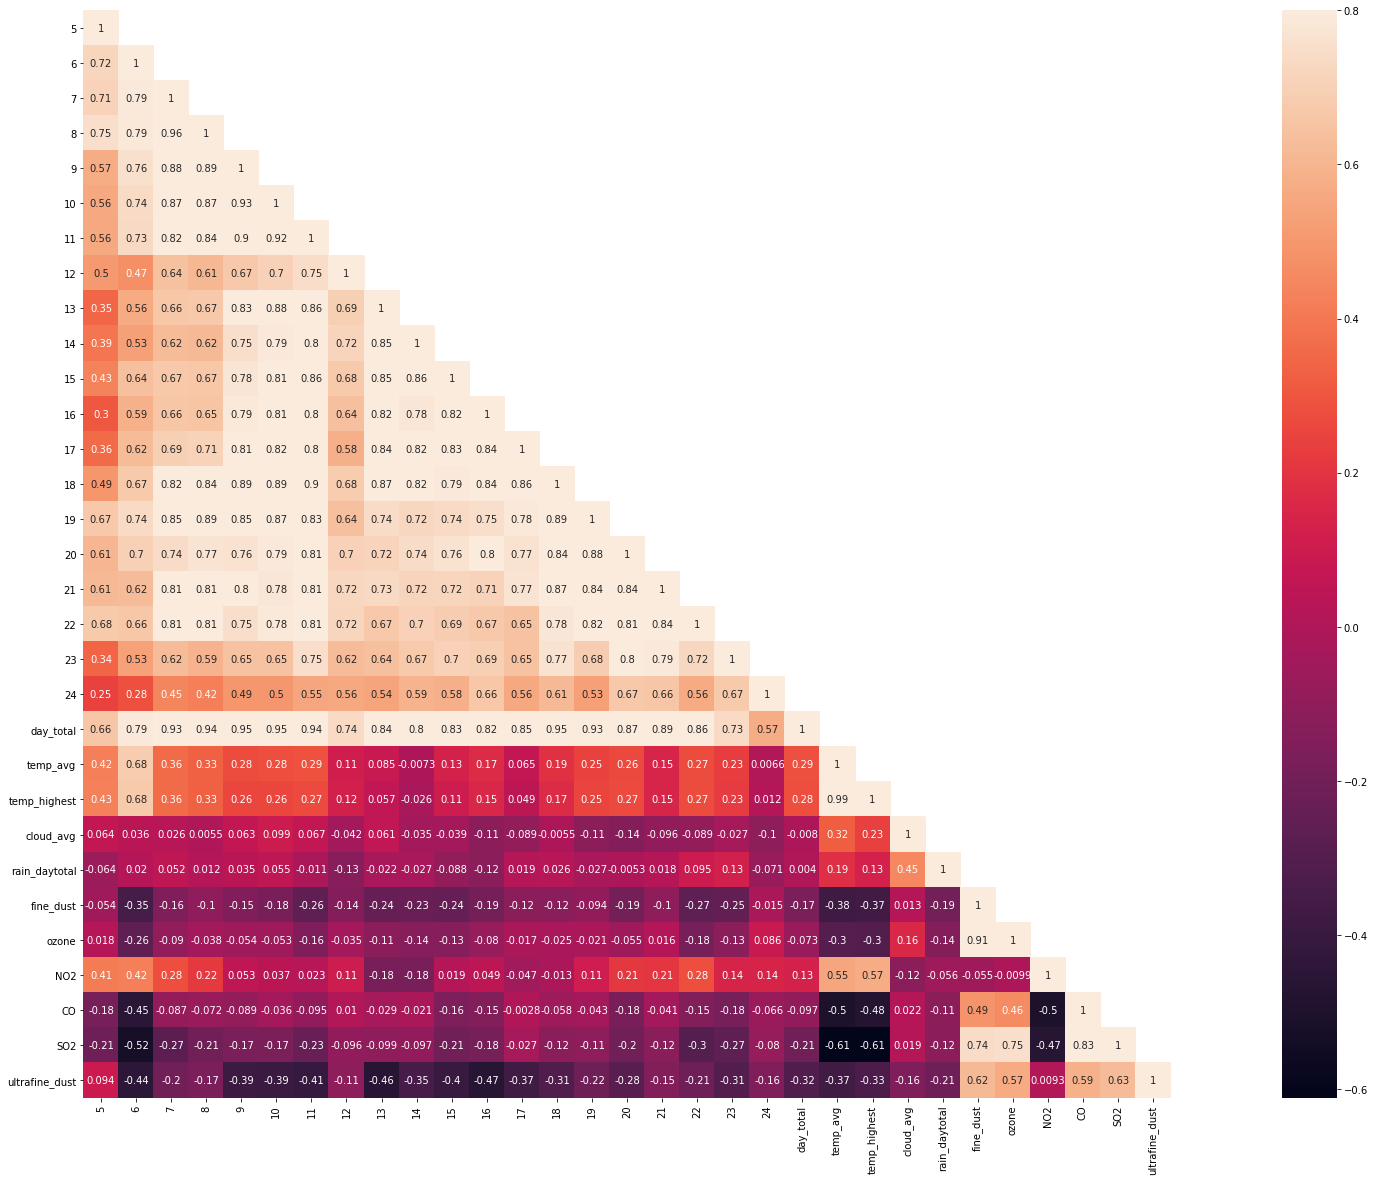

In [ ]:
corr_mat = df_corr.corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(40, 20)
sns.heatmap(
    corr_mat,
    mask=mask,
    vmax=.8,
    square=True,
    annot=True
);


In [ ]:
df_cleanset[(df_cleanset['station_name'] == '강남') | (df_cleanset['station_name'] == '홍대입구') ]

,date,line_num,station_num,station_name,board_alight,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,day_total,temp_avg,temp_highest,cloud_avg,rain_daytotal,fine_dust,ozone,NO2,CO,SO2,ultrafine_dust,month,dayofweek,season
62,2019-01-01,2,222,강남,1,1612,1425,852,742,731,953,1197,1346,1796,1846,2362,2596,3095,3067,2696,3159,3638,3987,1772,0,38872,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
63,2019-01-01,2,222,강남,0,160,719,733,1064,1755,1582,1898,2571,2988,3019,2896,3000,3497,3236,2269,1917,1438,1178,790,2,36712,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
96,2019-01-01,2,239,홍대입구,1,6023,3954,2343,1592,1505,1657,2242,2312,2922,3040,3590,4308,4851,5038,4666,5059,5931,6414,2914,25,70386,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
97,2019-01-01,2,239,홍대입구,0,184,582,483,774,1410,1993,2986,4617,5255,5593,5651,5992,6104,5725,4105,3609,2654,2174,1542,526,61959,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
612,2019-01-02,2,222,강남,1,366,813,1881,3288,2441,2426,3314,4091,5644,5748,6738,7427,9917,17311,11456,8468,10387,9977,4242,826,116761,-4.9,0.2,0.0,0.0,33.08,21.36,0.01256,0.03524,0.676,0.00464,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199797,2019-12-30,2,239,홍대입구,0,174,787,1484,4856,4700,3833,4760,6130,6609,6702,6661,7496,8257,11600,8168,4918,3742,3110,2312,1124,97423,2.7,6.8,7.5,0.4,36.76,25.68,0.01132,0.03304,0.628,0.00308,12,0,3
200314,2019-12-31,2,222,강남,1,609,889,1685,2505,2019,2077,2970,4068,5312,6353,8234,9281,10542,12333,8425,6783,6589,6868,3291,1639,102472,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200315,2019-12-31,2,222,강남,0,500,1761,5269,13006,11519,6372,5056,5151,5748,6253,6165,6043,7512,7580,5759,3918,3546,3260,2026,2350,108794,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200348,2019-12-31,2,239,홍대입구,1,1082,1018,2333,3059,2384,2360,2927,3422,4006,4649,5332,6623,7499,7636,6222,6098,6631,7681,4036,2248,87246,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3


In [ ]:
df_gang3 = df_cleanset.copy(deep=True)

is_gang3 = (df_cleanset['station_num'] == 239)
is_alighting = df_cleanset['board_alight'] == 0

df_gang3 = df_gang3.loc[
    (is_gang3) & (is_alighting) & (on_tuesday),
    :
]


In [ ]:
df_gang3

,date,line_num,station_num,station_name,board_alight,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,day_total,temp_avg,temp_highest,cloud_avg,rain_daytotal,fine_dust,ozone,NO2,CO,SO2,ultrafine_dust,month,dayofweek,season
97,2019-01-01,2,239,홍대입구,0,184,582,483,774,1410,1993,2986,4617,5255,5593,5651,5992,6104,5725,4105,3609,2654,2174,1542,526,61959,-5.0,-0.6,3.4,0.0,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
3947,2019-01-08,2,239,홍대입구,0,168,722,1461,5489,4949,3450,3653,4436,5157,5161,4971,5394,6335,9187,7462,3765,2926,2318,1576,669,79249,-3.5,0.5,0.0,0.0,40.72,19.16,0.01968,0.02440,0.532,0.00520,1,1,3
7797,2019-01-15,2,239,홍대입구,0,153,722,1297,5066,4952,3256,3749,4355,4882,4930,5090,4925,6346,8395,7866,3591,2935,2407,1841,709,77467,-1.7,2.6,3.8,0.0,140.00,89.72,0.01976,0.02988,0.928,0.00532,1,1,3
11647,2019-01-22,2,239,홍대입구,0,170,768,1241,5133,5118,3289,3784,4382,5325,5383,5202,5163,6448,9071,7840,3897,2931,2376,1668,699,79888,1.7,7.1,1.1,0.0,65.56,31.28,0.00984,0.04480,0.944,0.00528,1,1,3
15497,2019-01-29,2,239,홍대입구,0,181,766,1337,5117,4784,3406,3539,4537,5304,5177,5054,5257,6575,9313,7879,3782,3022,2381,1785,679,79875,-0.2,7.0,2.1,0.0,68.76,22.28,0.00880,0.04112,0.636,0.00516,1,1,3
19347,2019-02-05,2,239,홍대입구,0,62,229,349,504,603,908,1395,2196,2645,3005,3385,3722,3995,4304,3588,3043,2575,2066,1492,701,40767,2.8,10.1,3.9,0.0,83.92,27.20,0.01420,0.03992,0.708,0.00516,2,1,3
23197,2019-02-12,2,239,홍대입구,0,170,717,1380,4877,5167,3380,3887,4909,6047,5837,5665,5993,6960,9698,7995,3987,3218,2474,1825,689,84875,-0.6,3.7,5.6,0.0,58.64,37.96,0.02208,0.03236,0.740,0.00568,2,1,3
27047,2019-02-19,2,239,홍대입구,0,167,720,1391,5011,4956,3817,3972,5083,5488,5063,5179,5499,6167,8789,7827,3886,2886,2533,1575,714,80723,1.4,3.0,9.4,4.6,43.44,34.20,0.00840,0.04264,0.676,0.00404,2,1,3
30897,2019-02-26,2,239,홍대입구,0,182,725,1360,4903,5148,3536,4364,5782,6138,5793,6201,6152,7039,9673,8363,4194,3087,2633,1705,757,87735,5.2,12.0,3.6,0.0,52.44,27.16,0.01720,0.04060,0.664,0.00508,2,1,3
34747,2019-03-05,2,239,홍대입구,0,183,705,1678,5806,6769,3762,3229,3886,4275,3939,4180,5458,5934,8702,7046,3640,2860,2220,1605,634,76511,8.4,12.9,8.6,0.0,191.36,139.00,0.03724,0.03384,0.952,0.00560,3,1,0


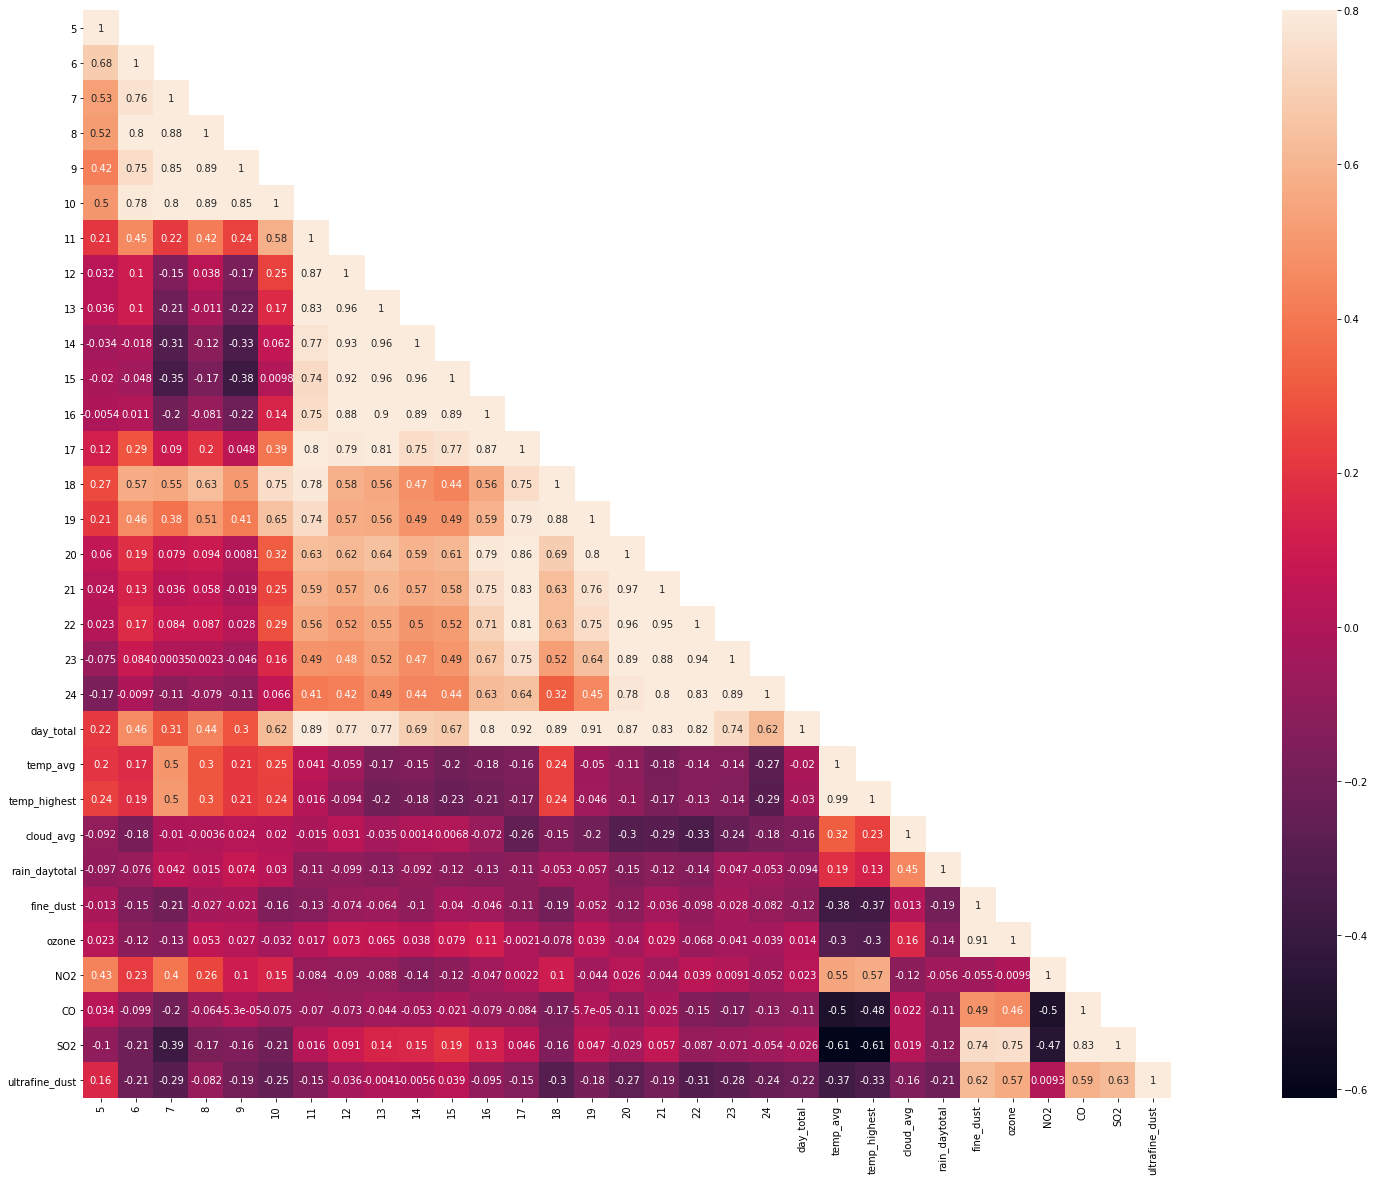

In [ ]:
draw_corr_heatmap(df_gang3)

# 그래프 분석

In [ ]:
df_melt = df_merged.copy(deep=True)

In [ ]:
df_melt

,date,line_num,station_num,station_name,board_alight,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,day_total,temp_avg,temp_highest,cloud_avg,rain_daytotal,fine_dust,ozone,NO2,CO,SO2,ultrafine_dust,month,dayofweek,season
0,2019-01-01,1,150,서울역,1,348,321,348,741,940,1401,2166,2844,3055,2341,3370,3226,3447,3277,2898,2590,3004,2234,970,38,39559,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
1,2019-01-01,1,150,서울역,0,222,821,808,961,1472,1737,1917,2316,2539,2360,2743,2491,2572,2060,1991,1683,1217,764,456,149,31279,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
2,2019-01-01,1,151,시청,1,87,98,143,206,280,395,500,672,673,868,946,958,1062,1146,1119,992,904,570,211,6,11836,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
3,2019-01-01,1,151,시청,0,48,237,323,571,577,648,744,960,996,875,964,733,746,606,374,311,268,177,144,57,10359,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
4,2019-01-01,1,152,종각,1,669,318,217,203,333,365,666,802,1103,1294,1843,1870,2129,2024,1806,1796,1780,1296,497,31,21042,-5.0,-0.6,3.4,NaN,39.36,26.12,0.01472,0.03156,0.692,0.00428,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200799,2019-12-31,8,2825,신흥,0,20,87,86,243,208,189,205,327,347,381,382,501,510,562,493,378,301,257,154,163,5794,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200800,2019-12-31,8,2826,수진,1,111,224,542,813,436,343,267,350,297,285,407,427,436,395,245,219,155,126,68,82,6228,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200801,2019-12-31,8,2826,수진,0,27,97,115,433,259,198,207,283,381,376,404,373,463,501,452,354,332,322,256,163,5996,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3
200802,2019-12-31,8,2827,모란,1,73,95,342,482,253,210,253,281,377,350,303,366,375,418,242,199,152,189,126,65,5151,-7.9,-4.5,1.3,0.0,24.44,14.92,0.02188,0.01600,0.380,0.00284,12,1,3


In [ ]:
df_melt = df_melt.loc[
    (df_melt['station_num'] == 2516) &
    (df_melt['board_alight'] == 0),
    '5':
]

In [ ]:
df_melt.columns

Index(['5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', 'day_total', 'temp_avg',
       'temp_highest', 'cloud_avg', 'rain_daytotal', 'fine_dust', 'ozone',
       'NO2', 'CO', 'SO2', 'ultrafine_dust', 'month', 'dayofweek', 'season'],
      dtype='object')

In [ ]:
drop_feat = [
    'day_total', 'temp_avg', 'temp_highest', 'cloud_avg', 'rain_daytotal',
    'fine_dust', 'ozone', 'NO2', 'CO', 'SO2', 'ultrafine_dust'
]
df_melt.drop(drop_feat, axis=1, inplace=True)
df_melt

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,month,dayofweek,season
249,18,145,145,246,390,319,338,549,494,522,543,594,738,596,407,371,287,288,179,11,1,1,3
799,118,489,1273,3936,1677,630,687,681,658,611,655,724,928,1659,1586,741,511,475,242,111,1,2,3
1349,108,535,1163,3959,1776,801,744,705,736,755,599,767,1009,1642,1486,722,574,521,261,127,1,3,3
1899,132,517,1078,3933,1901,765,745,812,660,716,743,872,1071,1831,1783,864,589,542,374,187,1,4,3
2449,82,472,293,617,920,773,993,1171,1177,950,797,873,1063,1132,734,520,404,389,277,9,1,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198295,95,622,1053,3922,2013,932,935,1019,1110,948,1032,1171,1720,2559,2054,876,722,593,434,233,12,4,3
198847,68,439,435,680,1060,944,1397,1364,1248,1063,1128,1306,1589,1439,846,677,528,533,335,44,12,5,3
199399,28,402,240,268,542,422,613,636,751,771,734,839,906,797,646,464,370,311,240,30,12,6,3
199951,83,509,1150,3706,1961,1081,934,998,970,901,1010,1122,1267,1934,1598,786,640,557,345,162,12,0,3


In [ ]:
id_variables = [
    'month', 'dayofweek', 'season'
]

value_variables = list(df_melt.columns[:-3])

In [ ]:
df_melt = pd.melt(
    df_melt,
    id_vars=id_variables,
    value_vars=value_variables,
    var_name='hour',
    value_name='alight'
)

In [ ]:
df_melt

,month,dayofweek,season,hour,alight
0,1,1,3,5,18
1,1,2,3,5,118
2,1,3,3,5,108
3,1,4,3,5,132
4,1,5,3,5,82
...,...,...,...,...,...
7295,12,4,3,24,233
7296,12,5,3,24,44
7297,12,6,3,24,30
7298,12,0,3,24,162


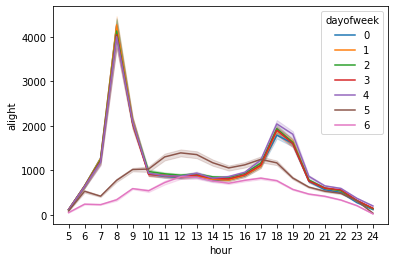

In [ ]:
sns.lineplot(data=df_melt, x='hour', y='alight', hue='dayofweek');

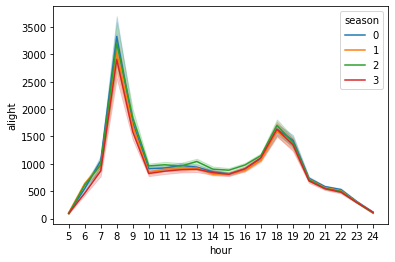

In [ ]:
sns.lineplot(data=df_melt, x='hour', y='alight', hue='season')

In [ ]:
df_melt['dayofweek'].unique()

[1, 2, 3, 4, 5, 6, 0]
Categories (7, int64): [1, 2, 3, 4, 5, 6, 0]

# 아주 단순하게 비교

In [ ]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))



In [ ]:
df_dataset = df_merged[
    (df_merged['station_num'] == 2516) &
    (df_merged['board_alight'] == 0)
]

## 추가 Feature를 사용하지 않은 경우

In [ ]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(df_dataset, test_size=0.2)

In [ ]:
trainset = trainset.loc[
    :,
    [
        '8', 'month', 'dayofweek', 'season'
    ]
]

In [ ]:
y_train = trainset['8']
X_train = trainset.drop('8', axis=1)

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

rfModel = RandomForestRegressor(n_estimators=100)
y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)
preds = rfModel.predict(X=X_train)
print(
    "RMSLE Value For Random Forest: ",
    rmsle(
        np.exp(y_train_log),
        np.exp(preds),
        False
    )
)



RMSLE Value For Random Forest:  0.4394841229496927


In [ ]:
testset = testset.loc[
    :,
    [
        '8', 'month', 'dayofweek', 'season'
    ]
]

In [ ]:
y_test = testset['8']
X_test = testset.drop('8', axis=1)

In [ ]:
pred_test = rfModel.predict(X=X_test)
print(
    "Testset Validation: ", 
    rmsle(
        np.exp(np.log1p(y_test)),
        np.exp(pred_test),
        False
    )
)

Testset Validation:  0.6085741550050191


## 추가 Feature  사용

In [ ]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(df_dataset, test_size=0.2)

In [ ]:
trainset.dropna(
    subset=['ultrafine_dust'],
    inplace=True
)

testset.dropna(
    subset=['ultrafine_dust'],
    inplace=True
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
trainset = trainset.loc[
    :,
    ['8', 'month', 'dayofweek', 'season', 'temp_avg', 'ultrafine_dust']
]

testset = testset.loc[
    :,
    ['8', 'month', 'dayofweek', 'season', 'temp_avg', 'ultrafine_dust']
]

In [ ]:
y_train = trainset['8']
X_train = trainset.drop('8', axis=1)

In [ ]:
X_train['ultrafine_dust'].isnull().sum()

0

In [ ]:
rfModel = RandomForestRegressor(n_estimators=100)
y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)
preds = rfModel.predict(X=X_train)
print(
    "RMSLE Value For Random Forest: ",
    rmsle(
        np.exp(y_train_log),
        np.exp(preds),
        False
    )
)



RMSLE Value For Random Forest:  0.25046544124360465


In [ ]:
y_test = testset['8']
X_test = testset.drop('8', axis=1)

In [ ]:
pred_test = rfModel.predict(X=X_test)
print(
    "Testset Validation: ", 
    rmsle(
        np.exp(np.log1p(y_test)),
        np.exp(pred_test),
        False
    )
)

Testset Validation:  0.38597050780741243


# 보다 현실적인 모형

# 지하철보조금은 미세먼지 정책일 수 있나?

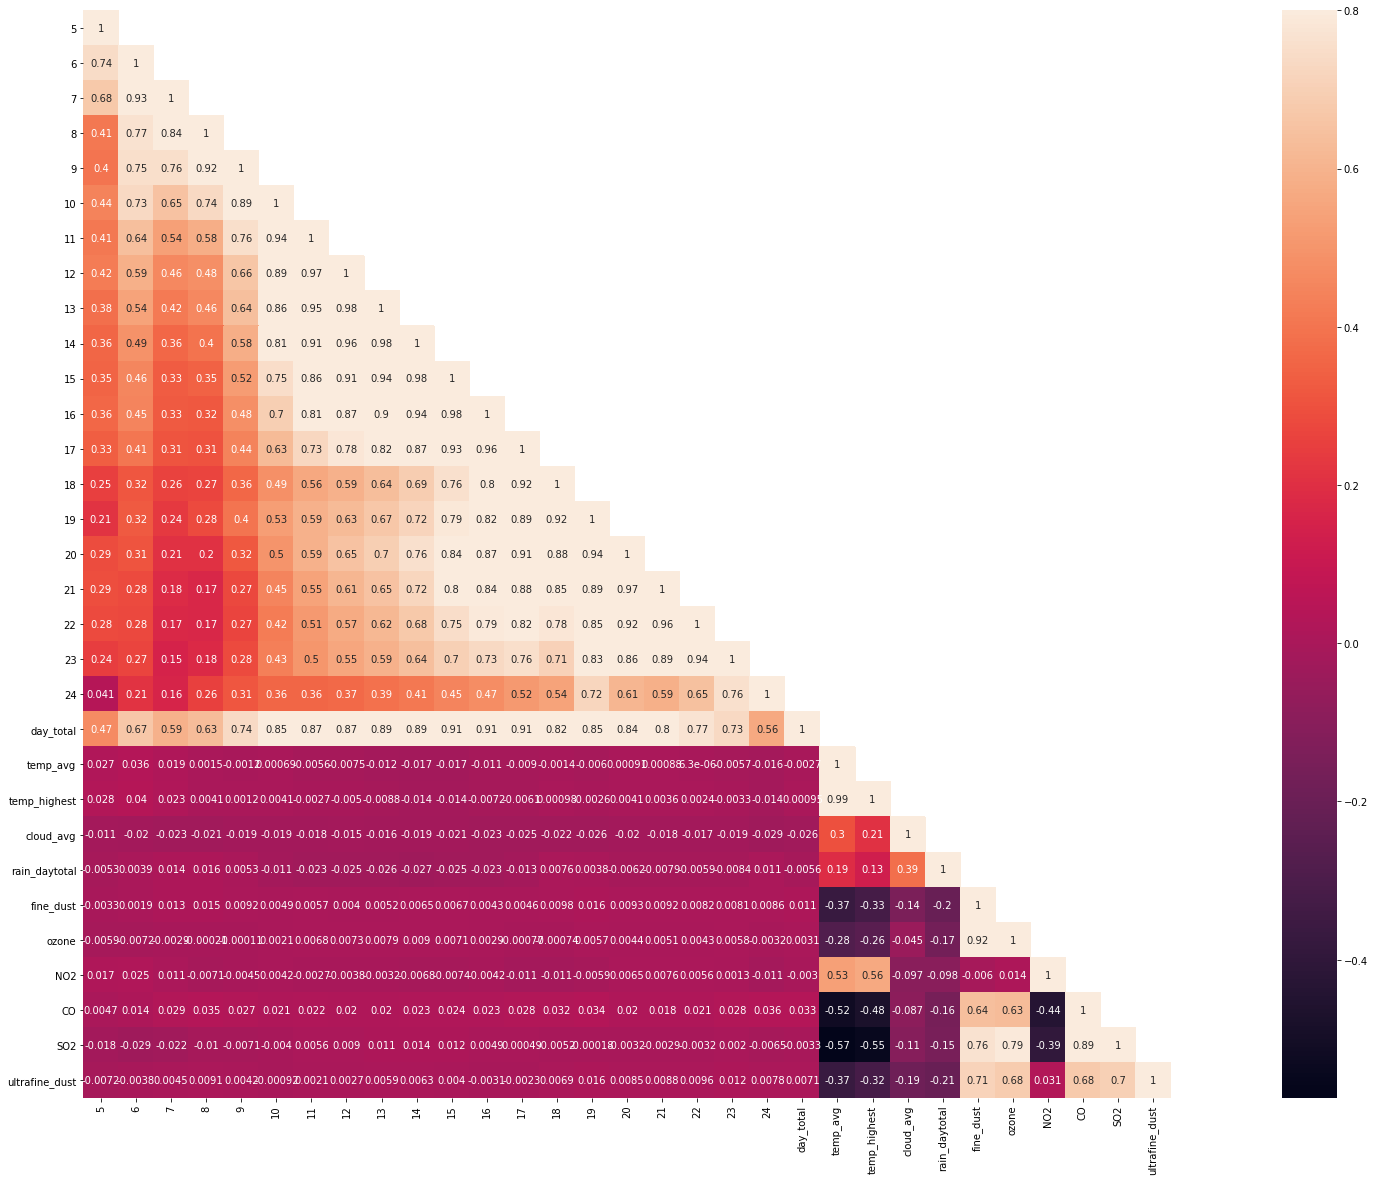

In [ ]:
df_subsidy = df_cleanset.copy(deep=True)

corr_mat = df_subsidy.corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(40, 20)
sns.heatmap(
    corr_mat,
    mask=mask,
    vmax=.8,
    square=True,
    annot=True
)

In [ ]:
df_subsln2 = df_cleanset.copy(deep=True)

corr_mat = df_subsln2.corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(40, 20)
sns.heatmap(
    corr_mat,
    mask=mask,
    vmax=.8,
    square=True,
    annot=True
)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_corr_heatmap(dataframe: pd.DataFrame):

    corr_mat = dataframe.corr()
    mask = np.array(corr_mat)
    mask[np.tril_indices_from(mask)] = False

    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    sns.heatmap(
        corr_mat, mask=mask, vmax=.8, square=True, annot=True
    )

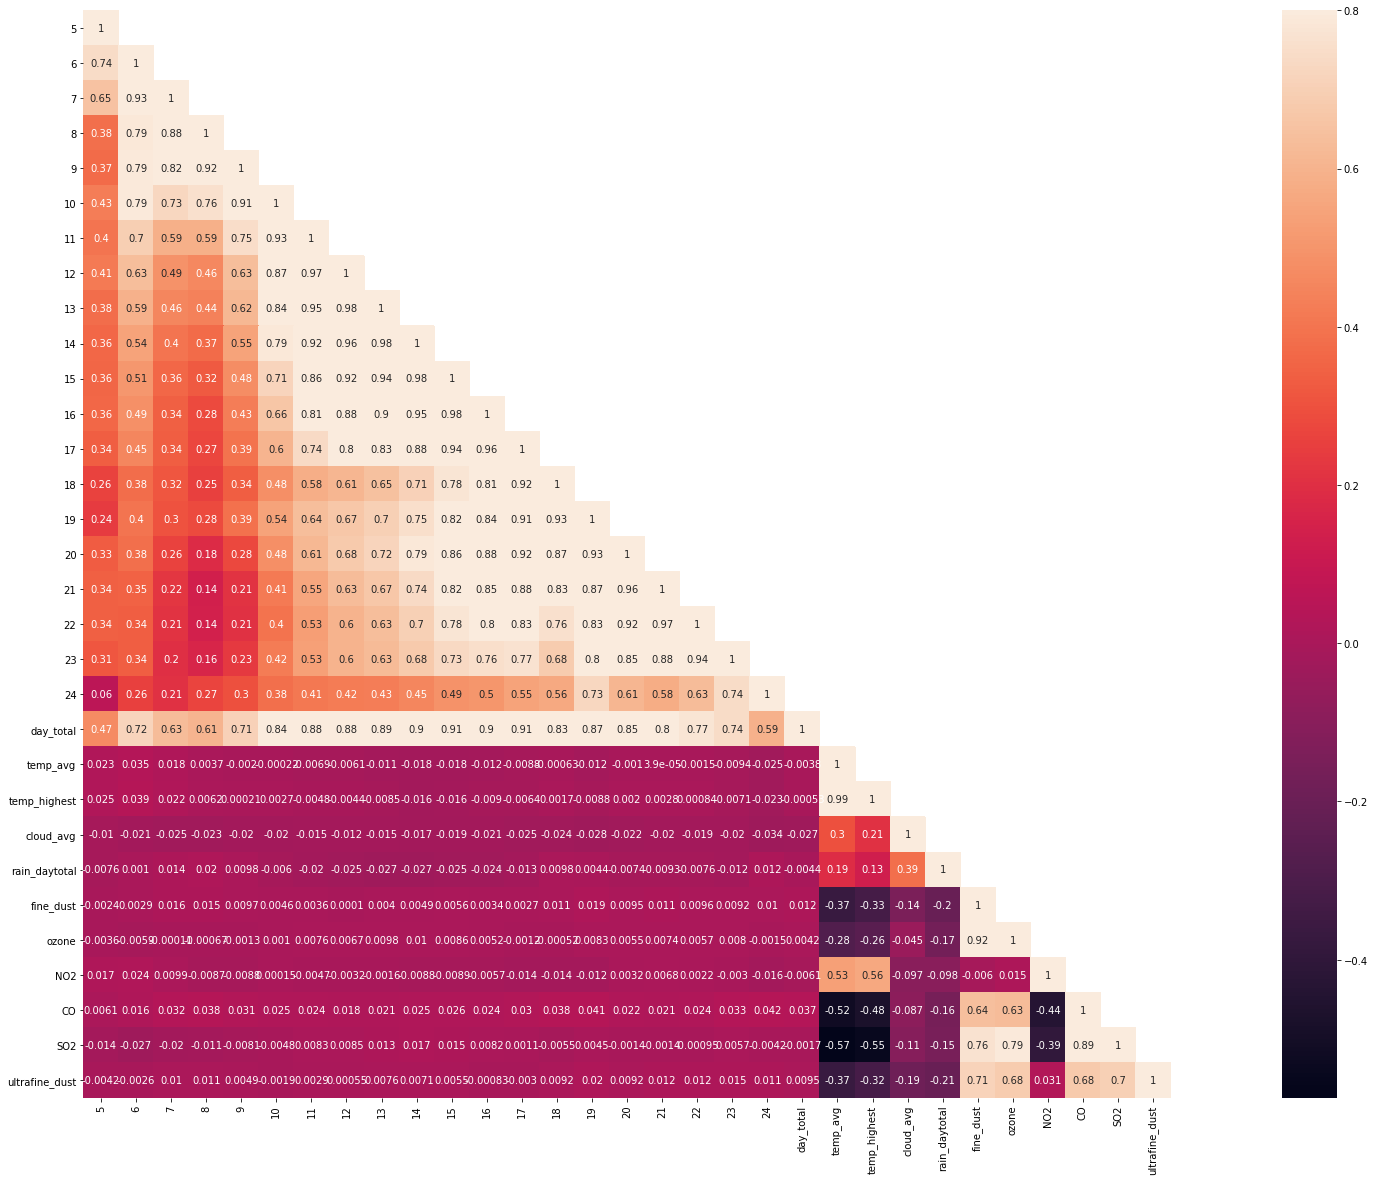

In [ ]:
df_line2 = df_cleanset.copy(deep=True)

df_line2 = df_line2[df_line2['line_num']==2]

draw_corr_heatmap(df_line2)